# Attrition Analysis

Primary datasource basic explanation :

前置假设（可在project report data source 部分做描述）：此数据在kaggle的发布时间为2017年，我们假设此数据就是从IBM的年度HR数据中采集的。不过数据经过了脱敏处理。 

## Libraries &amp; Version

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import altair as alt
import plotly.express as px
import scipy
import scipy.stats as stats 
import sklearn
from sklearn import preprocessing

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500



In [ ]:
!python --version

print('Pandas version: ', pd.__version__)
print('Numpy version: ', np.__version__)
print('Matplotlib version: ', mpl.__version__)
print('Seaborn version: ', sns.__version__)
print('Altair version: ', alt.__version__)
print('Scipy version: ', scipy.__version__)
print('Sklearn version: ', sklearn.__version__)

Python 3.7.11
Pandas version:  1.2.5
Numpy version:  1.19.5
Matplotlib version:  3.4.3
Seaborn version:  0.11.2
Altair version:  4.1.0
Scipy version:  1.7.1
Sklearn version:  0.24.2


## Loading data

In [ ]:
df = pd.read_csv('./IMB_attrition.csv')
df_ibm = df.copy()

In [ ]:
df_ibm.info()  # check the features and whether empty value exists

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
df_ibm.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
# Categorical Features Unique values 
object_col = []
for column in df_ibm.columns:
    if df_ibm[column].dtype == object and len(df_ibm[column].unique()) <= 30:
        object_col.append(column)
        print(f"{column} : {df_ibm[column].unique()}")
        print(df_ibm[column].value_counts())
        print("====================================")
object_col.remove('Attrition')

Attrition : ['Yes' 'No']
No     1233
Yes     237
Name: Attrition, dtype: int64
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64
Department : ['Sales' 'Research & Development' 'Human Resources']
Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64
EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64
Gender : ['Female' 'Male']
Male      882
Female    588
Name: Gender, dtype: int64
JobRole : ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human 

## Data Manipulation

The primary dataset has no empty value. So, no null issue should be treated. Our first data treatment is to transform the categorical data before we explore the correlation. The There are several features are required to be treated.
- Attrition : {"Yes":1, "No":0}
- BusinessTravel : {"Non-Travel":0, "Travel_Rarely":1, "Travel_Frequently":2}
- Department : {"Sales":0, "Research & Development":1, "Human Resources":2}
- EducationField: {"Other":0, "Life Sciences":1, "Human Resources":2, "Medical":3, "Marketing":4, "Technical Degree":5}
- Gender : {"Male":1, "Female":0}
- JobRole : {"Manager":0, "Sales Executive":1, "Sales Representative":2, 
            "Research Scientist":3, "Laboratory Technician":4, "Manufacturing Director":5, 
            "Healthcare Representative":6, "Human Resources":7, "Research Director":8}
- MaritalStatus : {"Single":0, "Married":1, "Divorced":2}
- Over18: all employees are over18. this column can be deleted.
- OverTime : {"Yes":1, "No":0}


In [ ]:
# categorical data transformation. pandas.Series.map, np.where, processing.LabelEncoder are all workable. Map is more explanable.

df_ibm['Attrition'] = df_ibm['Attrition'].map({'Yes':1, 'No':0})
df_ibm['BusinessTravel'] = df_ibm['BusinessTravel'].map({"Non-Travel":0, "Travel_Rarely":1, "Travel_Frequently":2})
df_ibm['Department'] = df_ibm['Department'].map({"Sales":0, "Research & Development":1, "Human Resources":2})
df_ibm['EducationField'] = df_ibm['EducationField'].map({"Other":0, "Life Sciences":1, "Human Resources":2, "Medical":3, \
                                                        "Marketing":4, "Technical Degree":5})
df_ibm['Gender'] = df_ibm['Gender'].map({'Male':1, 'Female':0})
df_ibm['JobRole'] = df_ibm['JobRole'].map({"Manager":0, "Sales Executive":1, "Sales Representative":2, "Research Scientist":3, \
                                            "Laboratory Technician":4, "Manufacturing Director":5, "Healthcare Representative":6,\
                                             "Human Resources":7, "Research Director":8})
df_ibm['MaritalStatus'] = df_ibm['MaritalStatus'].map({"Single":0, "Married":1, "Divorced":2})
df_ibm['OverTime'] = df_ibm['OverTime'].map({'Yes':1, 'No':0})


In [ ]:
# delete the column

df_ibm = df_ibm.drop(['Over18'], axis=1)

In [ ]:
df_ibm.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,1,1102,0,1,2,1,1,1,2,0,94,3,2,1,4,0,5993,19479,8,1,11,3,1,80,0,8,0,1,6,4,0,5
1,49,0,2,279,1,8,1,1,1,2,3,1,61,2,2,3,2,1,5130,24907,1,0,23,4,4,80,1,10,3,3,10,7,1,7
2,37,1,1,1373,1,2,2,0,1,4,4,1,92,2,1,4,3,0,2090,2396,6,1,15,3,2,80,0,7,3,3,0,0,0,0
3,33,0,2,1392,1,3,4,1,1,5,4,0,56,3,1,3,3,1,2909,23159,1,1,11,3,3,80,0,8,3,3,8,7,3,0
4,27,0,1,591,1,2,1,3,1,7,1,1,40,3,1,4,2,1,3468,16632,9,0,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
df_ibm.info() # data is ready for explore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   int64
 2   BusinessTravel            1470 non-null   int64
 3   DailyRate                 1470 non-null   int64
 4   Department                1470 non-null   int64
 5   DistanceFromHome          1470 non-null   int64
 6   Education                 1470 non-null   int64
 7   EducationField            1470 non-null   int64
 8   EmployeeCount             1470 non-null   int64
 9   EmployeeNumber            1470 non-null   int64
 10  EnvironmentSatisfaction   1470 non-null   int64
 11  Gender                    1470 non-null   int64
 12  HourlyRate                1470 non-null   int64
 13  JobInvolvement            1470 non-null   int64
 14  JobLevel                  1470 non-null 

### Attrition Distribution

In [ ]:
df_attri = df_ibm.groupby(['Attrition'])['Attrition'].count()
df_attri

Attrition
0    1233
1     237
Name: Attrition, dtype: int64

<AxesSubplot:title={'center':'Attrition Distribution - Data balance'}, xlabel='Attrition', ylabel='numbers'>

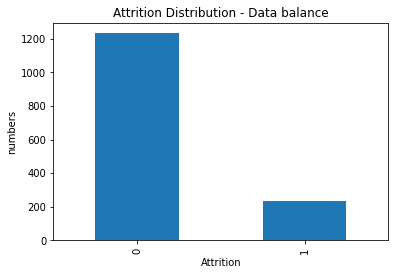

In [ ]:
df_attri.plot(kind='bar', title='Attrition Distribution - Data balance', ylabel='numbers', xlabel = 'Attrition')

In [ ]:
turnover_rate = len(df_ibm[df_ibm['Attrition']==1]) / len(df_ibm)
turnover_rate

0.16122448979591836

- From the IBM data, we can find the turnover rate is about 16%. Based on the data of [LinkedIn](https://www.linkedin.com/business/talent/blog/talent-strategy/industries-with-the-highest-turnover-rates#:~:text=Tech%20companies%20(software%2C%20not%20hardware,round%20out%20the%20top%20five.), in 2017, Technology industry suffered the highest turnover rate amongst all the indsutries, achieved 13.2% based on LinkedIn data, while, it is still 3% lower than that of IBM. So, it deserves us to further explore the reasons and try to find the correlations.

- IBM Data distribution about attribution is highly unbalanced. So, we should take care when we design learning algorithm for predictions and select the algorithm evaluation metrics.

### General Correlations with Attrition

In [ ]:
corr_matrix =  df_ibm.corr(method='kendall')
corr_matrix['Attrition'].sort_values(ascending=False)

Attrition                   1.000000
OverTime                    0.246118
BusinessTravel              0.123712
DistanceFromHome            0.066765
EducationField              0.059543
Gender                      0.029453
NumCompaniesWorked          0.026854
MonthlyRate                 0.012462
PerformanceRating           0.002889
HourlyRate                 -0.005504
EmployeeNumber             -0.008469
PercentSalaryHike          -0.020190
Education                  -0.027817
RelationshipSatisfaction   -0.039069
DailyRate                  -0.046549
TrainingTimesLastYear      -0.047154
YearsSinceLastPromotion    -0.047753
JobRole                    -0.048717
WorkLifeBalance            -0.049365
Department                 -0.067866
EnvironmentSatisfaction    -0.088377
JobSatisfaction            -0.094305
JobInvolvement             -0.113526
Age                        -0.142012
YearsWithCurrManager       -0.152006
MaritalStatus              -0.156481
YearsInCurrentRole         -0.156711
Y

Text(0.5, 1.0, 'Attrition Correlation (Kendall)')

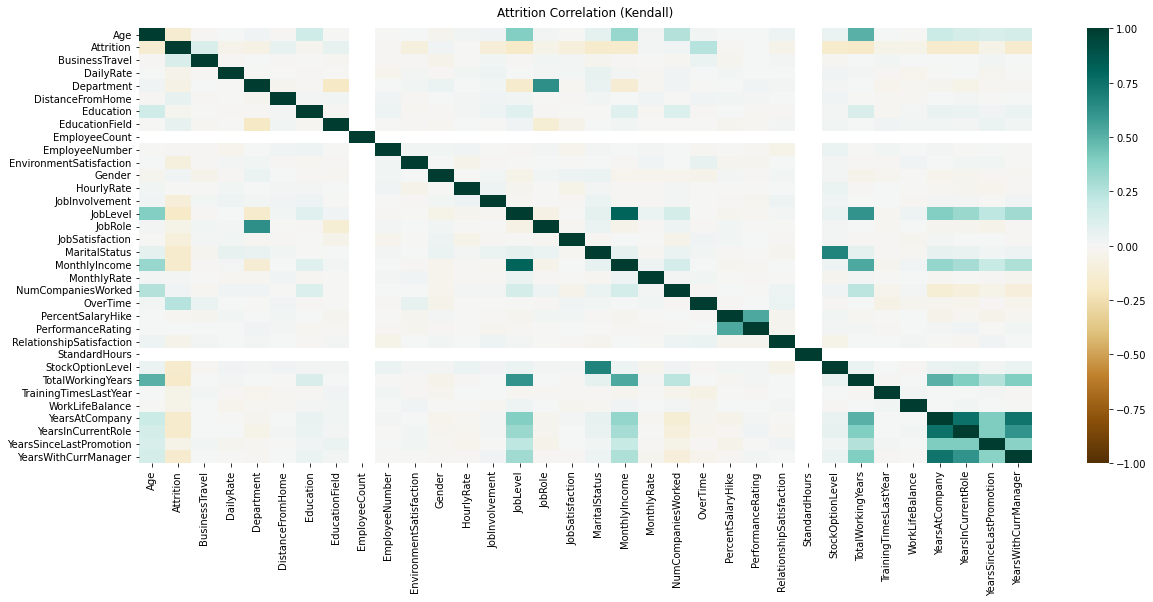

In [ ]:
plt.figure(figsize=(20,8))
corr_heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='BrBG')
corr_heatmap.set_title("Attrition Correlation (Kendall)",pad=12)


Text(0.5, 1.0, 'Features Correlation with Attrition')

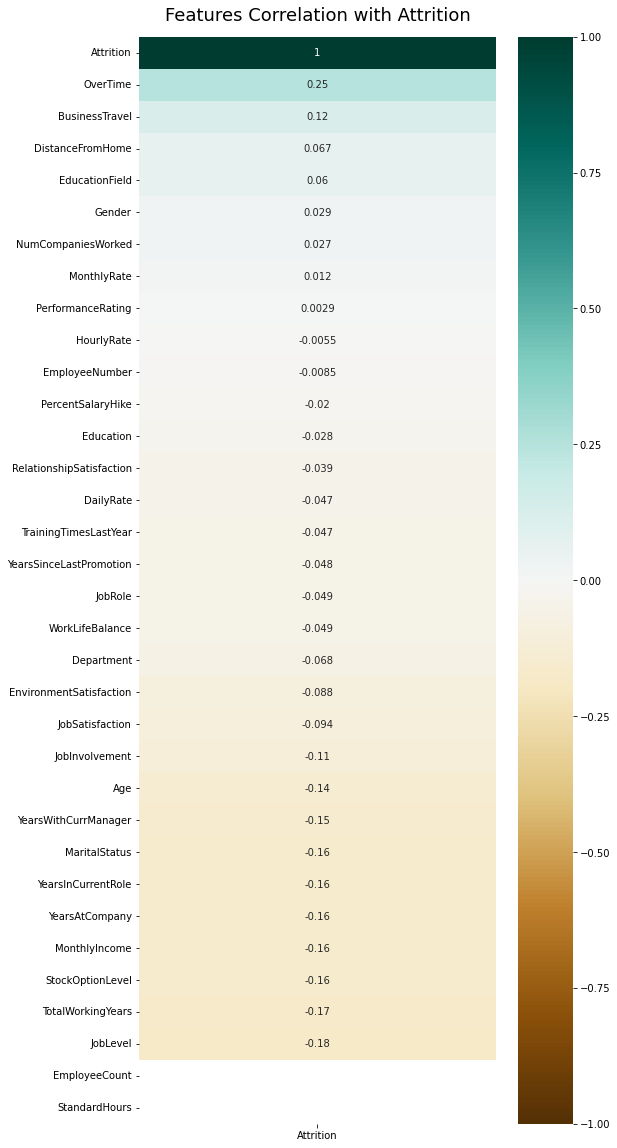

In [ ]:
plt.figure(figsize = (8,20))

corr_heatmap2 = sns.heatmap(corr_matrix[['Attrition']].sort_values(by = 'Attrition', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

corr_heatmap2.set_title('Features Correlation with Attrition', fontdict={'fontsize':18}, pad=16)


### How many people left who suffered overtime ?

In [ ]:
# general overtime percentage
ot_rate = len(df_ibm[df_ibm['OverTime']==1])/ len(df_ibm)
print("General OT rate: ", "{:.1%}".format(ot_rate))

# the percentage that OT conditions suffered by people left 
df_left = df_ibm[df_ibm['Attrition']==1]
ot_rate_left = len(df_left[df_left['OverTime']==1])/ len(df_left)
print("OT rate of the Attrition: ", "{:.1%}".format(ot_rate_left))

General OT rate:  28.3%
OT rate of the Attrition:  53.6%


### Department &amp; OverTime &amp; Attrition

In [ ]:
# which department suffered Attrition the worst ?
print("Attrition counts by Department:","\n",df_left.groupby('Department')['Department'].count())

# which department suffered OT in worst ?
# Department : {"Sales":0, "Research & Development":1, "Human Resources":2}
print("Overtime conditions of the Attrition by Department: ","\n",df_left.groupby(['Department', 'OverTime'])['Department'].count())


# staff numbers by Department 
print("Employee counts by Department: ", "\n", df_ibm.groupby(['Department'])['Department'].count())

Attrition counts by Department: 
 Department
0     92
1    133
2     12
Name: Department, dtype: int64
Overtime conditions of the Attrition by Department:  
 Department  OverTime
0           0           44
            1           48
1           0           59
            1           74
2           0            7
            1            5
Name: Department, dtype: int64
Employee counts by Department:  
 Department
0    446
1    961
2     63
Name: Department, dtype: int64


- 离职人数绝对值，R&D 占比最高，其次是 Sales 和 HR。 
- 离职的部门相对值。 Sales最高(20.6%), R&D (13.8%), HR (19.0%)
- 所以R&D离职人数高，是因为部门基数高，比例上来讲，还是Sales最高。
- 在探索离职人群的加班情况时，R&D 的占比最高 55.6%， Sales 52.2%, HR 41.7%.

但是到底是不是加班导致离职呢？ 从这里不能验证。下一步我们探索跟加班最直接相关的三个指标，工作满意度，工作生活平衡 和 收入。

### 工作满意度

In [ ]:
df_ibm['JobSatisfaction'].unique()

array([4, 2, 3, 1])

In [ ]:
df_satisfy = df_ibm.groupby(['Department','JobSatisfaction'])['JobSatisfaction'].count().reset_index(name='counts')
df_dept = df_ibm.groupby(['Department'])['Department'].count().reset_index(name='counts_dept')
df_satisfy = pd.merge(df_satisfy, df_dept, on='Department', how='outer')
df_satisfy['percent'] = df_satisfy['counts'] / df_satisfy['counts_dept']
df_satisfy['Department'] = df_satisfy['Department'].map({0:"Sales", 1:"R&D", 2:"HR"})
df_satisfy

,Department,JobSatisfaction,counts,counts_dept,percent
0,Sales,1,86,446,0.192825
1,Sales,2,86,446,0.192825
2,Sales,3,127,446,0.284753
3,Sales,4,147,446,0.329596
4,R&D,1,192,961,0.199792
5,R&D,2,174,961,0.181061
6,R&D,3,300,961,0.312175
7,R&D,4,295,961,0.306972
8,HR,1,11,63,0.174603
9,HR,2,20,63,0.317460


In [ ]:
# Normalized stacked Bar Chart
base = alt.Chart(df_satisfy).mark_bar().encode(
    x=alt.X('percent:Q', stack="normalize", axis= None),
    y=alt.Y('Department:N', axis =alt.Axis(labelFontSize=12, title=None)),
    order = alt.Order('JobSatisfaction:O', sort='descending')
)

bars = base.encode(
    detail = 'JobSatisfaction:O',
    color= alt.Color('JobSatisfaction:O', scale = alt.Scale(scheme='redblue')),
)

text = base.mark_text(dx=-15, dy=3, color='black').encode(
    text=alt.Text('percent:Q', format='.1%')
)

alt.layer(bars, text).properties(
    title = 'Job Satisfaction Level Percentage by Department',
    width = 400,
    height = 200
)

alt.LayerChart(...)

In [ ]:
df_dept_left = df_left.groupby('Department')['Department'].count().reset_index(name='counts_left_depart')
df_satisfy_left = df_left.groupby(['Department','JobSatisfaction'])['JobSatisfaction'].count().reset_index(name='counts')
df_satisfy_left = pd.merge(df_satisfy_left, df_dept_left, on='Department', how='outer')
df_satisfy_left['Department'] = df_satisfy_left['Department'].map({0:"Sales", 1:"R&D", 2:"HR"})
df_satisfy_left

,Department,JobSatisfaction,counts,counts_left_depart
0,Sales,1,23,92
1,Sales,2,20,92
2,Sales,3,27,92
3,Sales,4,22,92
4,R&D,1,38,133
5,R&D,2,24,133
6,R&D,3,43,133
7,R&D,4,28,133
8,HR,1,5,12
9,HR,2,2,12


In [ ]:
# JobSatisfaction comparison

# general JobSatisfaction mean value by department
satisfy_mean = df_satisfy.groupby('Department').apply(lambda x: sum(x.JobSatisfaction * x.counts)/x.counts.sum())
print("General mean value of Job Satisfaction: \n", satisfy_mean)

# JobSatisfaction mean value of Attritions by department
satisfy_mean_left = df_satisfy_left.groupby('Department').apply(lambda x: sum(x.JobSatisfaction * x.counts)/x.counts.sum())
print("Job Satisfaction mean value of Attritions: \n", satisfy_mean_left)

General mean value of Job Satisfaction: 
 Department
HR       2.603175
R&D      2.726327
Sales    2.751121
dtype: float64
Job Satisfaction mean value of Attritions: 
 Department
HR       2.166667
R&D      2.458647
Sales    2.521739
dtype: float64


JobSatisfaction一共分了4级， 1-4， 分数越高表示对工作满意度约高。
 - 1 ： 不满意
 - 2 ： 比较不满意
 - 3 ： 比较满意
 - 4 ： 满意

我们发现虽然R&D 和 Sales 的加班比例最高，Sales 的离职比例最高，但是两个部门的工作满意度的满意比例都超过部门总人数的60%。
在离职的人群中，R&D 和 Sales 员工的工作满意度平均分超过2.7分，略低于总平均分 0.2 - 0.3分。 HR 的总平均分刚刚达到2.6， 离职人群的平均分已经明显在不满意的范围。

### 收入情况

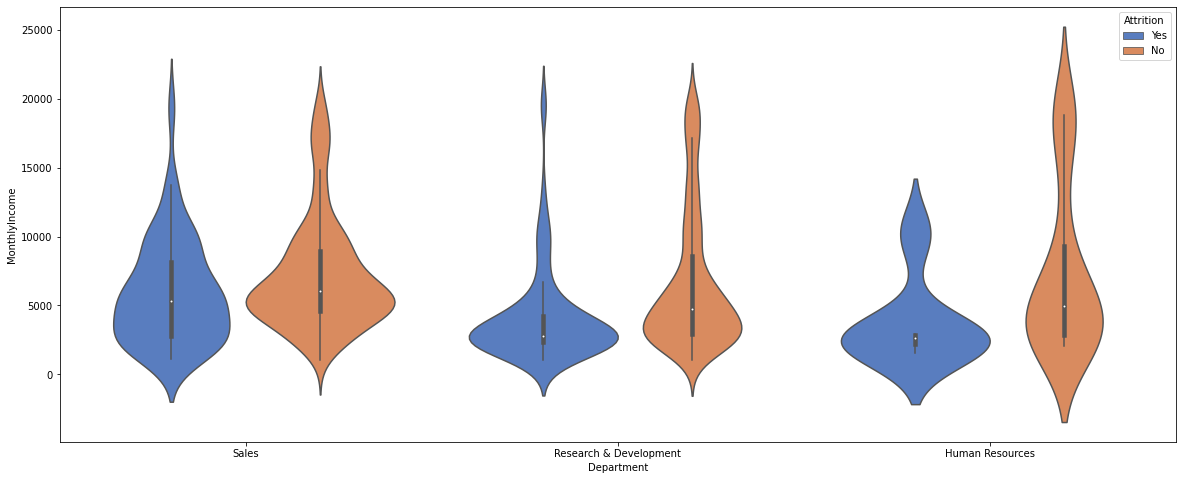

In [ ]:
# Monthly income distribution by department
plt.figure(figsize=(20,8))
ax = sns.violinplot(x='Department', y='MonthlyIncome', hue='Attrition', data=df, palette='muted')

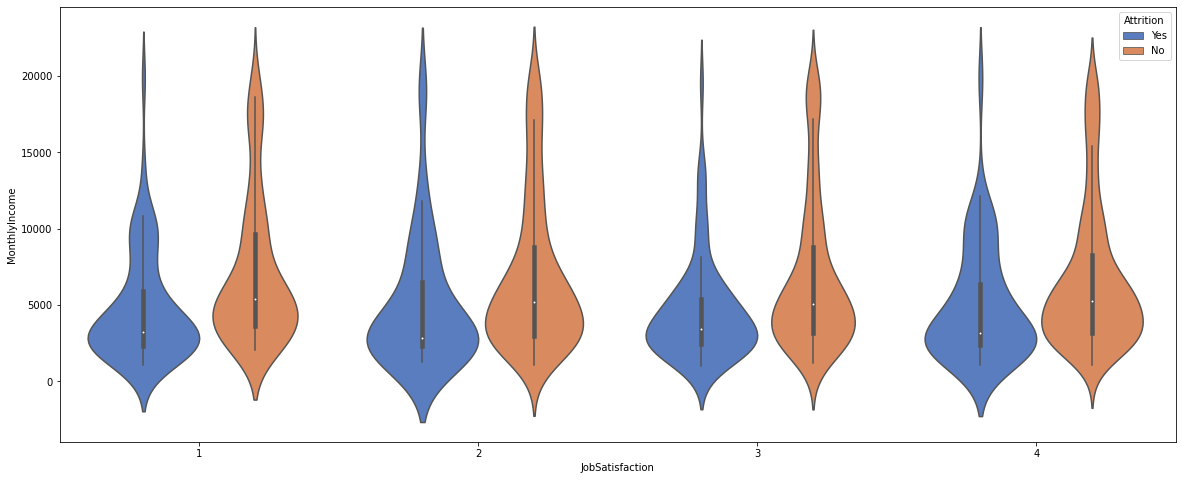

In [ ]:
plt.figure(figsize=(20,8))
ax1 = sns.violinplot(x='JobSatisfaction', y='MonthlyIncome', hue='Attrition', data=df, palette='muted')

- 从部门看，离职人员的中位数工资都低于未离职人员的中位数。
- 从工作满意度看，几乎在每个工作满意度级别的群体中，离职员工的中位数公司都远远低于为离职的员工。 尤其是工作满意度高的群里，作为员工，尽管对工作比较满意，但是收入低了，还是会离职。

### 离职群里的工作年限，本公司在职年限，岗位年限分布 

In [ ]:
# total working years
df_totalworkyear= df_left.groupby('TotalWorkingYears')['TotalWorkingYears'].count().reset_index(name='counts')
df_totalworkyear.columns = ['year', 'counts']
df_totalworkyear['cumpercent'] = df_totalworkyear['counts'].cumsum()/df_totalworkyear['counts'].sum()
df_totalworkyear

,year,counts,cumpercent
0,0,5,0.021097
1,1,40,0.189873
2,2,9,0.227848
3,3,9,0.265823
4,4,12,0.316456
5,5,16,0.383966
6,6,22,0.476793
7,7,18,0.552743
8,8,16,0.620253
9,9,10,0.662447


In [ ]:
def years_pareto(df):
    """
    This is the basic demonstration of the approach. The basic pareto chart is composed of two parts. 
        - Bar : Distribution of the transaction amount with each countries, sorted in descending order.
        - Line : Cumulative percentage line 

    In this special cases, I won't sort the counts, because the sequence of years is better for me to 
    analyze the attrition condition by year interval if needed.
    """
    #sort_order = df['year'].tolist() # sort order

    # define the base of the chart, x axis is shared.
    base = alt.Chart(df).encode(
        x = alt.X('year:O', axis = alt.Axis(title = 'Years', titleFontSize=14))
    ).properties(
        width = 1000,
        height = 300
    )

    # plot the bars, defining bar size and opacity.
    bars = base.mark_bar(size=15, opacity=0.5).encode(
        y = alt.Y('counts:Q', axis = alt.Axis(title='Number of Attritions', titlePadding=10, titleFontSize=14))
    ).properties(
        width = 1000,
        height = 300
    )

    # plot the line
    line = base.mark_line(
        strokeWidth= 1.5,
        color = '#cb4154',
    ).encode(
        y = alt.Y('cumpercent:Q',
            axis = alt.Axis(title = 'Cumulative percentage', titlePadding=10, titleFontSize=14,format='.0%')),
        text = alt.Text('cumpercent:Q')
    )

    # plot the points
    points = base.mark_circle(
        strokeWidth = 3,
        color = '#cb4154',
    ).encode(
        y = alt.Y('cumpercent:Q', axis = None),
        text = alt.Text('cumpercent:Q')
    )

    # mark text for each point.
    points_text = points.mark_text(
        align = 'left',
        baseline = 'middle',
        dx = -10, # Nudges text to right so it doesn't appear on top of the bar
        dy = -10
    ).encode(
        y = alt.Y('cumpercent:Q', axis=None),
        text = alt.Text('cumpercent:Q', format='.0%'),
        color = alt.value('#cb4154')
    )


    Figure = (bars + line + points + points_text).resolve_scale(
        y = 'independent'
    ).configure_mark().configure_view(
        strokeWidth = 0
    )

    return Figure


In [ ]:
years_pareto(df_totalworkyear).properties(
        title = {
            'text': 'Attrition Distrition along the Total Working Years',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

In [ ]:
# Years At Company 

df_yearatcompany= df_left.groupby('YearsAtCompany')['YearsAtCompany'].count().reset_index(name='counts')
df_yearatcompany.columns = ['year', 'counts']
df_yearatcompany['cumpercent'] = df_yearatcompany['counts'].cumsum()/df_yearatcompany['counts'].sum()
df_yearatcompany

,year,counts,cumpercent
0,0,16,0.067511
1,1,59,0.316456
2,2,27,0.430380
3,3,20,0.514768
4,4,19,0.594937
5,5,21,0.683544
6,6,9,0.721519
7,7,11,0.767932
8,8,9,0.805907
9,9,8,0.839662


In [ ]:
years_pareto(df_yearatcompany).properties(
        title = {
            'text': 'Attrition Distrition by Years at Company',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

In [ ]:
# YearsInCurrentRole

df_yearcurrentrole= df_left.groupby('YearsInCurrentRole')['YearsInCurrentRole'].count().reset_index(name='counts')
df_yearcurrentrole.columns = ['year', 'counts']
df_yearcurrentrole['cumpercent'] = df_yearcurrentrole['counts'].cumsum()/df_yearcurrentrole['counts'].sum()

years_pareto(df_yearcurrentrole).properties(
        title = {
            'text': 'Attrition Distrition by Years in Current Roles',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

In [ ]:
df_left.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [ ]:
# YearsSinceLastPromotion

df_promot= df_left.groupby('YearsSinceLastPromotion')['YearsSinceLastPromotion'].count().reset_index(name='counts')
df_promot.columns = ['year', 'counts']
df_promot['cumpercent'] = df_promot['counts'].cumsum()/df_promot['counts'].sum()

years_pareto(df_promot).properties(
        title = {
            'text': 'Attrition Distrition by the Parameters of Years-Since-Last-Promotion',
            'subtitle':'Revised Pareto Chart (No Sorting Operation)',
            'subtitleFontWeight':500,
            'subtitleFontSize': 13,
            'anchor':'start',
            'fontSize': 20,
            'offset':20,
            'subtitlePadding':5

        }
    )

alt.LayerChart(...)

- 19% 的离职人员工作经验不到2年。
- 32% 的离职人员在IBM工作不到2年。
- 31% 的离职人员在此岗位上不满1年。
- 78% 的离职人员在3年以内得到了提升。

从上面四张图，2年以内的离职率很高，可以推想刚毕业的年轻人更容易离职，他们没有家庭的负担和牵绊，自由度很高。
虽然IBM的晋升制度理想，员工能够通过努力得到职位提升，但是还是因为其它原因离开。升职并不能左右员工的离职决定。

聚焦到Attrition Distribution by Years at Company 这张图，我们发现抛开只在IBM工作了2年的这部分。 在IBM工作3-10年的比例高达41%。
通常在一家公司工作3年以上，可以算是已经基本融入公司，基本认可公司价值观，与公司和同事产生了比较密切的链接。
这个数据集是2018年的，所以我们想看：
- 过去10年，IBM公司的财经信息在2017-2018 是否有一些比较异常的情况。
- 公司是否发生重组，业务切割，抛售 等等
- R&D 部门的headcount 在IBM比重非常大，我们想看看 Stackoverflow 在2018年對全球軟體工程師的問券調查, 看看行业内人员的薪资，工作满意度 等指标。

## Explore the secondary dataset

In [ ]:
df_stack = pd.read_csv('survey_results_public.csv', encoding="cp1252")
df_usa = df_stack[(df_stack['Country'] == 'United States') & (df_stack['Employment'] == 'Employed full-time')]
df_usa.head()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,HopeFiveYears,JobSearchStatus,LastNewJob,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,AssessJob10,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,AssessBenefits11,JobContactPriorities1,JobContactPriorities2,JobContactPriorities3,JobContactPriorities4,JobContactPriorities5,JobEmailPriorities1,JobEmailPriorities2,JobEmailPriorities3,JobEmailPriorities4,JobEmailPriorities5,JobEmailPriorities6,JobEmailPriorities7,UpdateCV,Currency,Salary,SalaryType,ConvertedSalary,CurrencySymbol,CommunicationTools,TimeFullyProductive,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,HackathonReasons,AgreeDisagree1,AgreeDisagree2,AgreeDisagree3,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,OperatingSystem,NumberMonitors,Methodology,VersionControl,CheckInCode,AdBlocker,AdBlockerDisable,AdBlockerReasons,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,AdsActions,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7,AIDangerous,AIInteresting,AIResponsible,AIFuture,EthicsChoice,EthicsReport,EthicsResponsible,EthicalImplications,StackOverflowRecommend,StackOverflowVisit,StackOverflowHasAccount,StackOverflowParticipate,StackOverflowJobs,StackOverflowDevStory,StackOverflowJobsRecommend,StackOverflowConsiderMember,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,WakeTime,HoursComputer,HoursOutside,SkipMeals,ErgonomicDevices,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,24-26 years,6-8 years,Moderately satisfied,Moderately satisfied,Working as a founder or co-founder of my own c...,"I?™m not actively looking, but I am open to ne...",Less than a year ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor?™s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,18-20 years,12-14 years,Neither satisfied nor dissatisfied,Slightly dissatisfied,Working as a founder or co-founder of my own c...,"I?™m not actively looking, but I am open to ne...",Less than a year ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A recruiter contacted me,U.S. dollars ($),NaN,NaN,NaN,NaN,NaN,Three to six months,Completed an industry certification program (e...,The official documentation and/or standards fo...,NaN,NaN,Disagree,Disagree,Strongly disagree,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,"SQL Server;Microsoft Azure (Tables, CosmosDB, ...","SQL Server;Microsoft Azure (Tables, CosmosDB, ...",Azure,Azure,NaN,Angular;.NET Core;React,Visual Studio;Visual Studio Code,Windows,2,Agile;Kanban;Scrum,Git,Multiple times per day,Yes,Yes,The ad-blocking software was causing display i...,Neither agree nor disagree,Somewhat agree,Somewhat agre

Based on the features of the secondary dataset, the following directions can be explored:
- Age interval. 在第二数据集的年龄特征里面，数据并不是一个单一的年龄值， 而是特定范围，可以支持我们对primary dataset 进行 bin 处理，整合分析。
- 国家和公司规模进行过滤处理，摘选出同类型同地域的公司进行比较。
- YearsCoding， 可筛选出primary dataset 中 R&D 部门，对应工作年限的比较。
- Salary （经过上面的过滤，单位都是美元）
- Gender

In [ ]:
df_buf = df_usa[['Employment', 'YearsCoding', 'UndergradMajor', 'CompanySize','YearsCodingProf', 
                'JobSatisfaction', 'CareerSatisfaction', 'Salary','SalaryType', 'Age', 'Gender']]



In [ ]:
df_buf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16031 entries, 2 to 98803
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Employment          16031 non-null  object
 1   YearsCoding         15842 non-null  object
 2   UndergradMajor      14934 non-null  object
 3   CompanySize         15452 non-null  object
 4   YearsCodingProf     14356 non-null  object
 5   JobSatisfaction     14187 non-null  object
 6   CareerSatisfaction  14237 non-null  object
 7   Salary              11523 non-null  object
 8   SalaryType          9167 non-null   object
 9   Age                 12733 non-null  object
 10  Gender              12676 non-null  object
dtypes: object(11)
memory usage: 1.5+ MB


In [ ]:
# Categorical Features Unique values 
object_col = []
for column in df_buf.columns:
    if df_buf[column].dtype == object and len(df_buf[column].unique()) <= 30:
        object_col.append(column)
        print(f"{column} : {df_buf[column].unique()}")
        print(df_buf[column].value_counts())
        print("====================================")
#object_col.remove('Attrition')

Employment : ['Employed full-time']
Employed full-time    16031
Name: Employment, dtype: int64
YearsCoding : ['24-26 years' '18-20 years' '9-11 years' '30 or more years' '3-5 years'
 '6-8 years' '12-14 years' '15-17 years' '21-23 years' '0-2 years'
 '27-29 years' nan]
6-8 years           3049
3-5 years           2737
9-11 years          2274
12-14 years         1699
15-17 years         1397
18-20 years         1388
30 or more years    1008
0-2 years            776
21-23 years          760
24-26 years          502
27-29 years          252
Name: YearsCoding, dtype: int64
UndergradMajor : ['Computer science, computer engineering, or software engineering'
 'Fine arts or performing arts (ex. graphic design, music, studio art)'
 nan 'A social science (ex. anthropology, psychology, political science)'
 'Web development or web design'
 'Another engineering discipline (ex. civil, electrical, mechanical)'
 'A humanities discipline (ex. literature, history, philosophy)'
 'A natural science (ex. b

In [ ]:


df_buf.loc[:, ['YearsCoding', 'YearsCodingProf']]  = df_buf.loc[:, ['YearsCoding', 'YearsCodingProf']].transform(lambda x: x.map(lambda x: 
                    {'0-2 years': 0, '3-5 years': 1, '6-8 years':2, 
                    '9-11 years':3, '12-14 years':4, '15-17 years':5,
                    '18-20 years':6, '21-23 years':7,
                    '24-26 years':8, '27-29 years':9, 
                    '30 or more years':10}.get(x,x)))


/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
df_buf['YearsCoding'].unique()

array([8.0, 6.0, 3.0, 10.0, 1.0, 2.0, 4.0, 5.0, 7.0, 0.0, 9.0, nan],
      dtype=object)

In [ ]:
df_buf.loc[:, ['JobSatisfaction', 'CareerSatisfaction']]  = df_buf.loc[:, ['JobSatisfaction', 'CareerSatisfaction']].transform(lambda x: x.map(lambda x: 
                    {'Extremely dissatisfied': 0, 'Moderately dissatisfied': 1, 'Slightly dissatisfied':2, 
                    'Neither satisfied nor dissatisfied':3, 'Slightly satisfied':4, 'Moderately satisfied':5,
                    'Extremely satisfied':6}.get(x,x)))


df_buf.loc[:, 'JobSearchStatus'] = df_buf.loc[:, 'JobSearchStatus'].transform(
    lambda x: x.map(lambda x: {'I am not interested in new job opportunities': 0, 
                               'I?™m not actively looking, but I am open to new opportunities': 0,
                              'I am actively looking for a job':1}.get(x,x)))

df_buf.loc[:, 'Age']  = df_buf.loc[:, 'Age'].transform(lambda x: x.map(lambda x: 
                    {'Under 18 years old': 0, '18 - 24 years old': 1, '25 - 34 years old':2, 
                    '35 - 44 years old':3, '45 - 54 years old':4, '55 - 64 years old':5,
                    '65 years or older':6}.get(x,x)))

df_buf3 = df_buf.loc[:, ['Hobby', 'OpenSource', 'YearsCoding', 'YearsCodingProf', 'JobSatisfaction', 'CareerSatisfaction', 
                        'JobSearchStatus', 'Age']]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d18beb40-c7f5-4252-8f44-871d7ae07af1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>